In [ ]:
#!pip install tensorflow

import os
import numpy as np              
import pandas as pd                              
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input , Lambda , Dense , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
# Load dataset direct From Kaggle to Google Colab page

#!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

#!cp /content/drive/MyDrive/kagelle/kaggle.json ~/.kaggle/kaggle.json

#%cd /content/data

#!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

#!unzip new-plant-diseases-dataset


In [ ]:
image_size = [224,224]

train_dir =  '/content/data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir  =  '/content/data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)

['Grape___healthy', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Peach___Bacterial_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Tomato___Leaf_Mold', 'Corn_(maize)___Common_rust_', 'Soybean___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Strawberry___Leaf_scorch', 'Squash___Powdery_mildew', 'Potato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Raspberry___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Potato___Late_blight', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Pepper,_bell___Bacterial_spot', 'Peach___healthy', 'Potato___healthy', 'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Corn_(maize

In [ ]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [ ]:
plants = []

NumberOfDiseases = 0

for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

The above cell extract the number of unique plants and number of unique diseases

In [ ]:
# unique plants in the dataset

print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Grape', 'Corn_(maize)', 'Pepper,_bell', 'Peach', 'Cherry_(including_sour)', 'Tomato', 'Soybean', 'Strawberry', 'Squash', 'Potato', 'Raspberry', 'Blueberry', 'Orange', 'Apple']


In [ ]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [ ]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Grape___healthy,1692
Corn_(maize)___healthy,1859
"Pepper,_bell___healthy",1988
Peach___Bacterial_spot,1838
Cherry_(including_sour)___Powdery_mildew,1683
Grape___Esca_(Black_Measles),1920
Grape___Black_rot,1888
Tomato___Leaf_Mold,1882
Corn_(maize)___Common_rust_,1907
Soybean___healthy,2022


Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

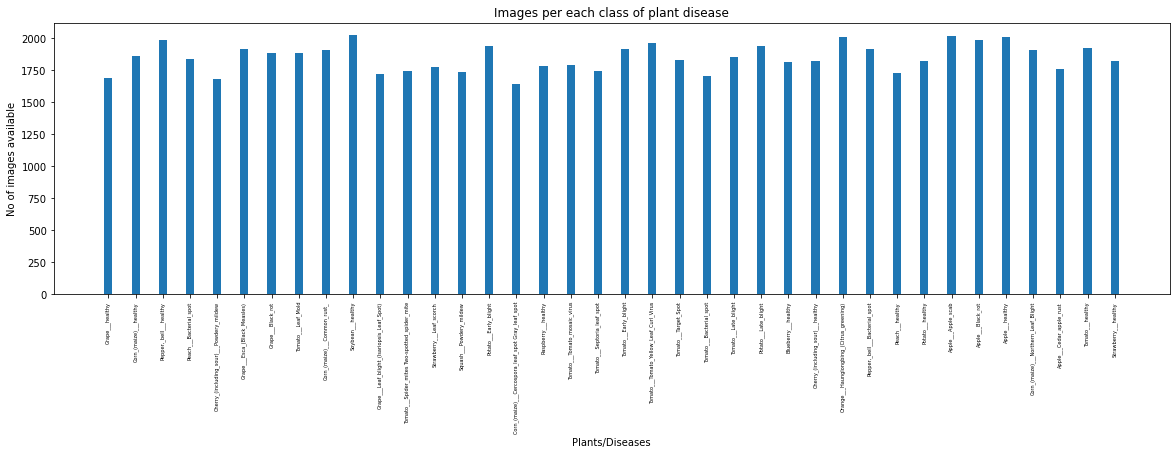

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(38)]

plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

Images available for training

In [ ]:
n_train = 0

for value in nums.values():
    n_train += value
    
print(f"There are {n_train} images for training")

There are 70295 images for training


**Data Preparation for training**

In [ ]:
# importing xception model and excluding top layer to input my specified data

xce = Xception(include_top=False , weights='imagenet' , input_shape=image_size + [3])

In [ ]:
# xception is transfer learning model ,it already pre-trained
for layer in xce.layers:
  layer.trainable = False

In [ ]:
# finding categories in data
folders = glob(train_dir +'/*')

In [ ]:
len(folders)

38

In [ ]:
x = Flatten()(xce.output)

In [ ]:
#At the end layer specifying output of the model ,here 38 categories are there and activation is softmax for categorical data

prediction = Dense(len(folders) , activation='softmax')(x)

model = Model(inputs = xce.input , outputs = prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# data augmentation , each image in different angles

train_datagen = ImageDataGenerator(
    shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
# creating train and test datasets

train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224, 224),
                                                  class_mode='categorical',
                                                  batch_size=32)

test_dataset = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                class_mode='categorical',
                                                batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Training model
# uncomment and run model

#r = model.fit(
#    train_dataset,
#    validation_data=test_dataset,
#    epochs = 10,
#    steps_per_epoch=len(train_dataset),
#    validation_steps=len(test_dataset)
#)

Epoch 1/10
2197/2197 [==============================] - 922s 418ms/step - loss: 3.4612 - accuracy: 0.7371 - val_loss: 2.6696 - val_accuracy: 0.8756
Epoch 2/10
2197/2197 [==============================] - 904s 411ms/step - loss: 2.3796 - accuracy: 0.8845 - val_loss: 2.1590 - val_accuracy: 0.9094
Epoch 3/10
2197/2197 [==============================] - 916s 417ms/step - loss: 2.1742 - accuracy: 0.9085 - val_loss: 2.8677 - val_accuracy: 0.8955
Epoch 4/10
2197/2197 [==============================] - 918s 418ms/step - loss: 2.0150 - accuracy: 0.9226 - val_loss: 2.5697 - val_accuracy: 0.9093
Epoch 5/10
2197/2197 [==============================] - 914s 416ms/step - loss: 1.8013 - accuracy: 0.9322 - val_loss: 3.5522 - val_accuracy: 0.8968
Epoch 6/10
2197/2197 [==============================] - 921s 419ms/step - loss: 1.7229 - accuracy: 0.9373 - val_loss: 2.3581 - val_accuracy: 0.9317
Epoch 7/10
2197/2197 [==============================] - 919s 418ms/step - loss: 1.5385 - accuracy: 0.9449 - val_

95% on training 93% on valid dataset , overall good accuracy

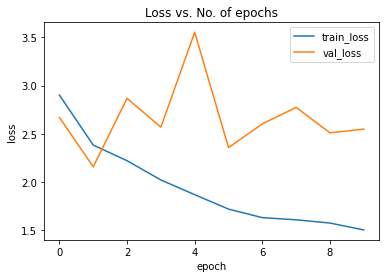

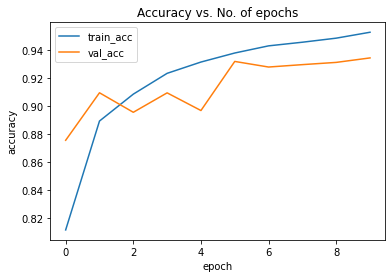

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'] , label = 'train_loss')
plt.plot(r.history['val_loss'] , label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');
    
plt.legend()
plt.show()

plt.plot(r.history['accuracy'] , label = 'train_acc')
plt.plot(r.history['val_accuracy'] , label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');
plt.legend()
plt.show()

In [ ]:
# save model in .h5 format

#model.save('model_xception.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/model_resnet50.h5')

In [ ]:
y_pred = model.predict(test_dataset)
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import numpy as np

y_pred = np.argmax(y_pred , axis=1)
y_pred

array([34, 36, 15, ...,  3,  0, 15])

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
# Load image from drive

#img = image.load_img('/content/data/test/test/AppleCedarRust1.JPG', target_size=(224,224))

#img = image.load_img('/content/data/test/test/AppleScab1.JPG', target_size=(224,224))

#img = image.load_img('/content/data/test/test/CornCommonRust1.JPG', target_size=(224,224))

img = image.load_img('/content/data/test/test/TomatoEarlyBlight6.JPG', target_size=(224,224))

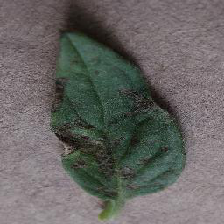

In [ ]:

img

In [ ]:
# convert file from img format to array format
x = image.img_to_array(img)

# rescale the images to obtain the range [0, 1] by dividing by 255
x = x/255

#increse dimention of the image
img_data=np.expand_dims(x,axis=0)

#prediction
model.predict(img_data)

# predicted value will not point at one value ,its always distributed with argmax you can find high probability value in the list
a=np.argmax(model.predict(img_data), axis=1)

print(a)

[29]


predicted as 29! means....its predicted as 29th category image in 38 category as tomato-early blight

In [ ]:
lis = os.listdir(train_dir)

In [ ]:
cc = dict()

for i,k in enumerate((lis)):
  cc[i] = k.replace('___' , ' ')

In [ ]:
cc

{0: 'Apple Apple_scab',
 1: 'Apple Black_rot',
 2: 'Apple Cedar_apple_rust',
 3: 'Apple healthy',
 4: 'Blueberry healthy',
 5: 'Cherry_(including_sour) Powdery_mildew',
 6: 'Cherry_(including_sour) healthy',
 7: 'Corn_(maize) Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize) Common_rust_',
 9: 'Corn_(maize) Northern_Leaf_Blight',
 10: 'Corn_(maize) healthy',
 11: 'Grape Black_rot',
 12: 'Grape Esca_(Black_Measles)',
 13: 'Grape Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape healthy',
 15: 'Orange Haunglongbing_(Citrus_greening)',
 16: 'Peach Bacterial_spot',
 17: 'Peach healthy',
 18: 'Pepper,_bell Bacterial_spot',
 19: 'Pepper,_bell healthy',
 20: 'Potato Early_blight',
 21: 'Potato Late_blight',
 22: 'Potato healthy',
 23: 'Raspberry healthy',
 24: 'Soybean healthy',
 25: 'Squash Powdery_mildew',
 26: 'Strawberry Leaf_scorch',
 27: 'Strawberry healthy',
 28: 'Tomato Bacterial_spot',
 29: 'Tomato Early_blight',
 30: 'Tomato Late_blight',
 31: 'Tomato Leaf_Mold',
 32: 'Tomato S